## T_2 Dephasing

Many experimental qubit systems feature some physical parameters which slowly
drift in time. These drifts enter the simulation as quasi-static noise,
meaning that they have an unpredictable value but are constant on the timescale
of qubit operations.

As a prominent example, we consider a qubit manipulated by resonant Rabi
driving in the rotating frame.

The Hamiltonian is given by

\begin{align}
H = \frac{\omega - \omega_0}{2} \sigma_z
+ \frac{u_x + \delta_x}{2} \sigma_x + \frac{u_y + \delta_y}{2} \sigma_y,
\end{align}

where $\omega_0$ is the resonance frequency and $\omega$ the driving frequency.
$u_x$ and $u_y$ are the driving amplitudes with respective quasi static
deviations $\delta_x$ and $\delta_x$ (for a detailed discussion have a
look at the notebook about rabi driving).

Slow shifts in the resonance frequency $\omega_0$ are perceived as detuning
$\delta_\omega = \omega - \omega_0$ by the qubit, such that we can have three
noise sources in total.

We implement the simulation of this Hamiltonian in qopt by a Monte Carlo 
method, where we sample the noise terms $\delta_\omega$, $\delta_x$ and 
$\delta_y$ from a Gaussian distribution of variance $V_\omega$, $V_x$ and $V_y$
respectively. We omit the Y-drive for simplicity:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from qopt import *

sigma_resonance = 1.5
sigma_drive = .2
n_time_steps = 200
n_noise_traces = 300
total_time = 10
rabi_frequency = 2 * np.pi

np.random.seed(0)

def create_solver(sigma_r, sigma_d):
    ntg = NTGQuasiStatic(
        standard_deviation=[sigma_r, sigma_d],
        n_samples_per_trace=n_time_steps,
        n_traces=n_noise_traces,
        always_redraw_samples=False,
        sampling_mode='monte_carlo'
    )

    solver = SchroedingerSMonteCarlo(
        h_drift=[0 * DenseOperator.pauli_0(), ] ,
        h_ctrl=[.5 * DenseOperator.pauli_x(), ],
        h_noise=[.5 * DenseOperator.pauli_z(),
                 .5 * DenseOperator.pauli_x()],
        tau=(total_time / n_time_steps) * np.ones(n_time_steps),
        noise_trace_generator=ntg,
        exponential_method='Frechet'
    )
    fid_ctrl_amps = rabi_frequency * np.expand_dims(np.ones(n_time_steps), 1)
    solver.set_optimization_parameters(fid_ctrl_amps)
    return solver

up_state = DenseOperator(np.asarray([[1], [0]]))

def measure_z(vec):
    """Calculates the expectation values of the sigma_z operator. """
    return np.real(((vec * vec.dag()) * DenseOperator.pauli_z()).tr())

### Noise on the Rabi Frequency

To better understand the distinct noise sources, we will first simulate them
separately. Quasi static noise on the Rabi-frequency leads the
typical $T_2^\ast$ decay, it as can be visualized by plotting the expectation
values of the $\sigma_z$ operator. If we start the simulation in the up-state
$\vert psi(t) \rangle =\vert 1 \rangle$ then the time evolution is given by

\begin{align}
\langle \psi(t) \vert \sigma_z \vert \psi(t)\rangle = \mathrm{cos}(u_x t)
\cdot e^{-\frac{1}{2} V_x t^2} =
\mathrm{cos}(u_x t) \cdot e^{-\frac{1}{2}(t/T_2^\ast)^2},
\end{align}

where $V_x$ is the variance of $\delta_x$. The full decay laws can be found
in the paper 'Rotating-frame relaxation as a noise spectrum analyser of a
superconducting qubit undergoing driven evolution' by
[Yan et. al., Nature Comms 4, 2337 (2013)](https://doi.org/10.1038/ncomms3337).

In [2]:
def average_monte_carlo_traces(sigma_r, sigma_d):
    solver = create_solver(sigma_r=sigma_r, sigma_d=sigma_d)
    propagators = solver.forward_propagators_noise

    z_projections = np.zeros(n_time_steps + 1)

    for props_per_trace in propagators:
        z_projections_per_trace = [
            measure_z(p * up_state) for p in props_per_trace
        ]
        z_projections += np.asarray(z_projections_per_trace)
    z_projections /= n_noise_traces
    return z_projections

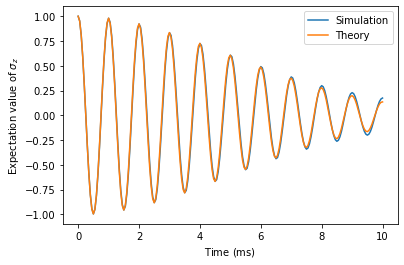

In [3]:
times = (total_time / n_time_steps) * np.arange(n_time_steps + 1)
z_projections = average_monte_carlo_traces(sigma_r=0, sigma_d=sigma_drive)

def t2_star_decay(t):
    return np.cos(t * rabi_frequency) * np.exp(-.5 * (t * sigma_drive) ** 2)

plt.plot(times, z_projections, label='Simulation')
plt.plot(times, t2_star_decay(times), label='Theory')
plt.xlabel('Time ($\mathrm{ms})$')
plt.ylabel('Expectation value of $\sigma_z$')
plt.legend()

### Noise on the Resonance Frequency

The noise on the resonance frequency leads to a rational decay law and cannot
be identified with a $T_2^\ast$ time:

\begin{align}
\langle \psi(t) \vert \sigma_z \vert \psi(t)\rangle = \mathrm{cos}(u_x t)
\cdot \left( 1 + \left[ \frac{V_\omega}{u_x} t\right]^2\right)^{\frac{-1}{4}}.
\end{align}

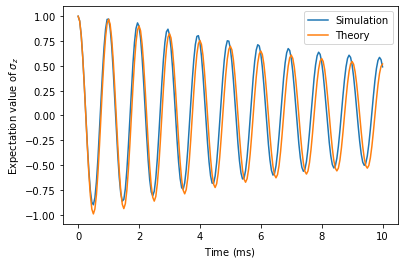

In [4]:
z_projections = average_monte_carlo_traces(sigma_r=sigma_resonance, sigma_d=0)

def resonance_noise_decay(t):
    return np.cos(t * rabi_frequency) * (1 + (
        sigma_resonance ** 2 / rabi_frequency * t) ** 2) ** -.25


plt.plot(times, z_projections, label='Simulation')
plt.plot(times, resonance_noise_decay(times), label='Theory')
plt.xlabel('Time ($\mathrm{ms})$')
plt.ylabel('Expectation value of $\sigma_z$')
plt.legend()

### Combination of Noise Sources

We can also apply both noise sources at the same time. Numerically this usually
requires the generation of more traces in the corresponding Monte Carlo
experiment.

We observe that the decaying laws multiply to:

\begin{align}
\langle \psi(t) \vert \sigma_z \vert \psi(t)\rangle = \mathrm{cos}(u_x t)
\cdot \left( 1 + \left[ \frac{V_\omega}{u_x} t\right]^2\right)^{\frac{-1}{4}}
\cdot e^{-\frac{1}{2} V_x t^2}.
\end{align}

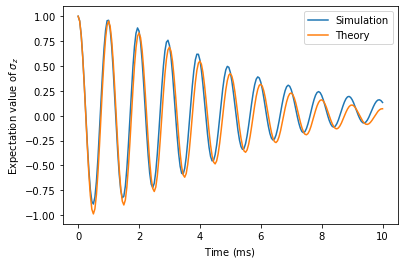

In [5]:
np.random.seed(0)
z_projections = average_monte_carlo_traces(sigma_r=sigma_resonance,
                                           sigma_d=sigma_drive)
def resonance_noise_decay(t):
    drive = np.cos(t * rabi_frequency)
    resonance_noise_factor =  (1 + (
        sigma_resonance ** 2 / rabi_frequency * t) ** 2) ** -.25
    drive_noise_factor = np.exp(-.5 * (t * sigma_drive) ** 2)
    return drive * resonance_noise_factor * drive_noise_factor


plt.plot(times, z_projections, label='Simulation')
plt.plot(times, resonance_noise_decay(times), label='Theory')
plt.xlabel('Time ($\mathrm{ms})$')
plt.ylabel('Expectation value of $\sigma_z$')
plt.legend()

The deviations between the simulation and the theoretically predicted decay
law originate mainly from the stochastic uncertainty in the Monte Carlo
method. The accuracy can be increased by increasing the number of noise
traces generated.